In [1]:
# utility imports
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import os

# dataset handling imports
from tensorflow.keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# ResNet50 model imports
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
NUM_CLASSES = 6
CHANNELS = 3

IMAGE_RESIZE = 224

BATCH_SIZE_TRAINING = 32
BATCH_SIZE_VALIDATION = 32
BATCH_SIZE_TESTING = 1

In [3]:
image_size = IMAGE_RESIZE
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    directory=r"D:\_Research\Radar_Video\Small_Chamber_Dopler_30-FPS\data\train",
    target_size=(image_size, image_size),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    
    batch_size=BATCH_SIZE_VALIDATION
)

valid_generator = train_datagen.flow_from_directory(
    directory=r"D:\_Research\Radar_Video\Small_Chamber_Dopler_30-FPS\data\valid",
    target_size=(image_size, image_size),
    color_mode="rgb",
    
    class_mode="categorical",
    shuffle=True,
    
    batch_size=BATCH_SIZE_VALIDATION
)

Found 4608 images belonging to 6 classes.
Found 1152 images belonging to 6 classes.


In [4]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))

# classification layer (6 neurons for 6 radar classes)
model.add(Dense(6, activation = 'softmax'))

model.layers[0].trainable = False

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [7]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [8]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=10,
        epochs = 5,
        validation_data=valid_generator,
        validation_steps=10,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.save_weights("best.hdf5")

Epoch 1/5
10/10 [==============================] - 28s 2s/step - loss: 8.7955 - accuracy: 0.2156 - val_loss: 3.4426 - val_accuracy: 0.3281
Epoch 2/5
10/10 [==============================] - 16s 2s/step - loss: 4.0741 - accuracy: 0.4062 - val_loss: 3.2144 - val_accuracy: 0.4750
Epoch 3/5
10/10 [==============================] - 16s 2s/step - loss: 1.1229 - accuracy: 0.7250 - val_loss: 0.3702 - val_accuracy: 0.8875
Epoch 4/5
10/10 [==============================] - 15s 1s/step - loss: 0.4087 - accuracy: 0.8531 - val_loss: 0.7482 - val_accuracy: 0.8250
Epoch 5/5
10/10 [==============================] - 15s 2s/step - loss: 0.2476 - accuracy: 0.9281 - val_loss: 0.1128 - val_accuracy: 0.9781


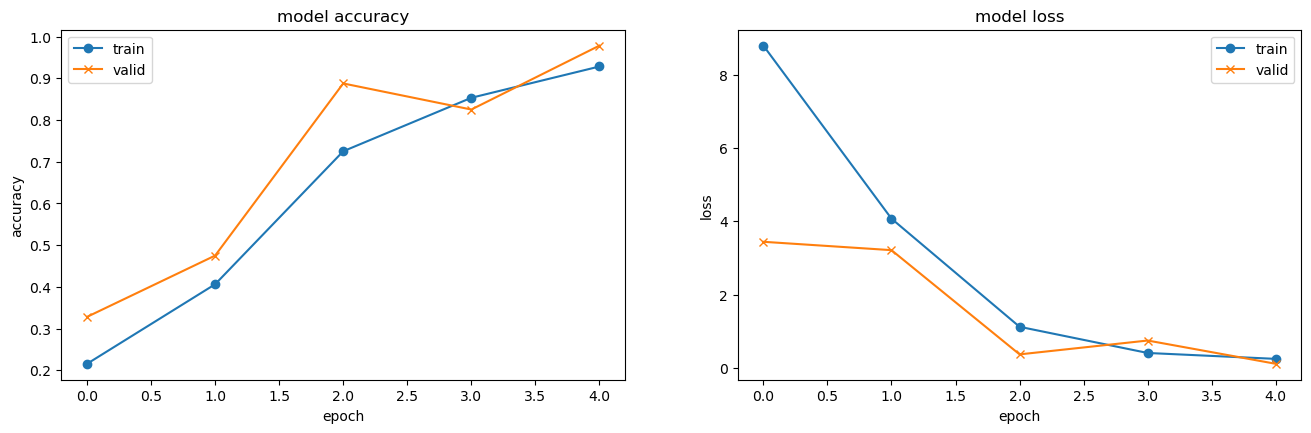

In [9]:
plt.figure(1, figsize = (16,10)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'], marker='o')  
plt.plot(fit_history.history['val_accuracy'], marker='x')  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'], marker='o')  
plt.plot(fit_history.history['val_loss'], marker='x')  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

## Inferencing


In [10]:
test_generator = train_datagen.flow_from_directory(
    directory=r"D:\_Research\Radar_Video\Small_Chamber_Dopler_30-FPS\data\test",
    target_size=(image_size, image_size),
    color_mode="rgb",
    batch_size=BATCH_SIZE_TESTING,
    class_mode=None,
    shuffle=False,
    seed=123
)

Found 1440 images belonging to 6 classes.


In [13]:
# Reset generator before predicting
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)

# get labels
inv_class_indices = {v: k for k, v in test_generator.class_indices.items()}

actual_class_indices = test_generator.classes

# overall accuracy
correct = np.sum(predicted_class_indices == actual_class_indices)
total = len(actual_class_indices)
overall_accuracy = correct / total * 100
print(f"\nOverall Accuracy: {correct}/{total} = {overall_accuracy:.2f}%")

# per class accuracy
from collections import defaultdict

class_correct = defaultdict(int)
class_total = defaultdict(int)

for pred_idx, actual_idx in zip(predicted_class_indices, actual_class_indices):
    class_total[actual_idx] += 1
    if pred_idx == actual_idx:
        class_correct[actual_idx] += 1

print("\nPer-Class Accuracy:")
for class_idx, total in class_total.items():
    correct = class_correct[class_idx]
    acc = correct / total * 100
    label = inv_class_indices[class_idx]
    print(f"{label}: {correct}/{total} = {acc:.2f}%")

1440/1440 [==============================] - 43s 30ms/step

Overall Accuracy: 1413/1440 = 98.12%

Per-Class Accuracy:
SC_NetGearBox_ALFoil: 240/240 = 100.00%
SC_NetGearBox_NoALFoil: 240/240 = 100.00%
SC_PlasticBottle_ALFoil: 237/240 = 98.75%
SC_PlasticBottle_NoALFoil: 216/240 = 90.00%
SC_WaterBottle_ALFoil: 240/240 = 100.00%
SC_WaterBottle_NoALFoil: 240/240 = 100.00%


-----------------------------------------------------------------
These are random images from the test dataset, there is no format
-----------------------------------------------------------------


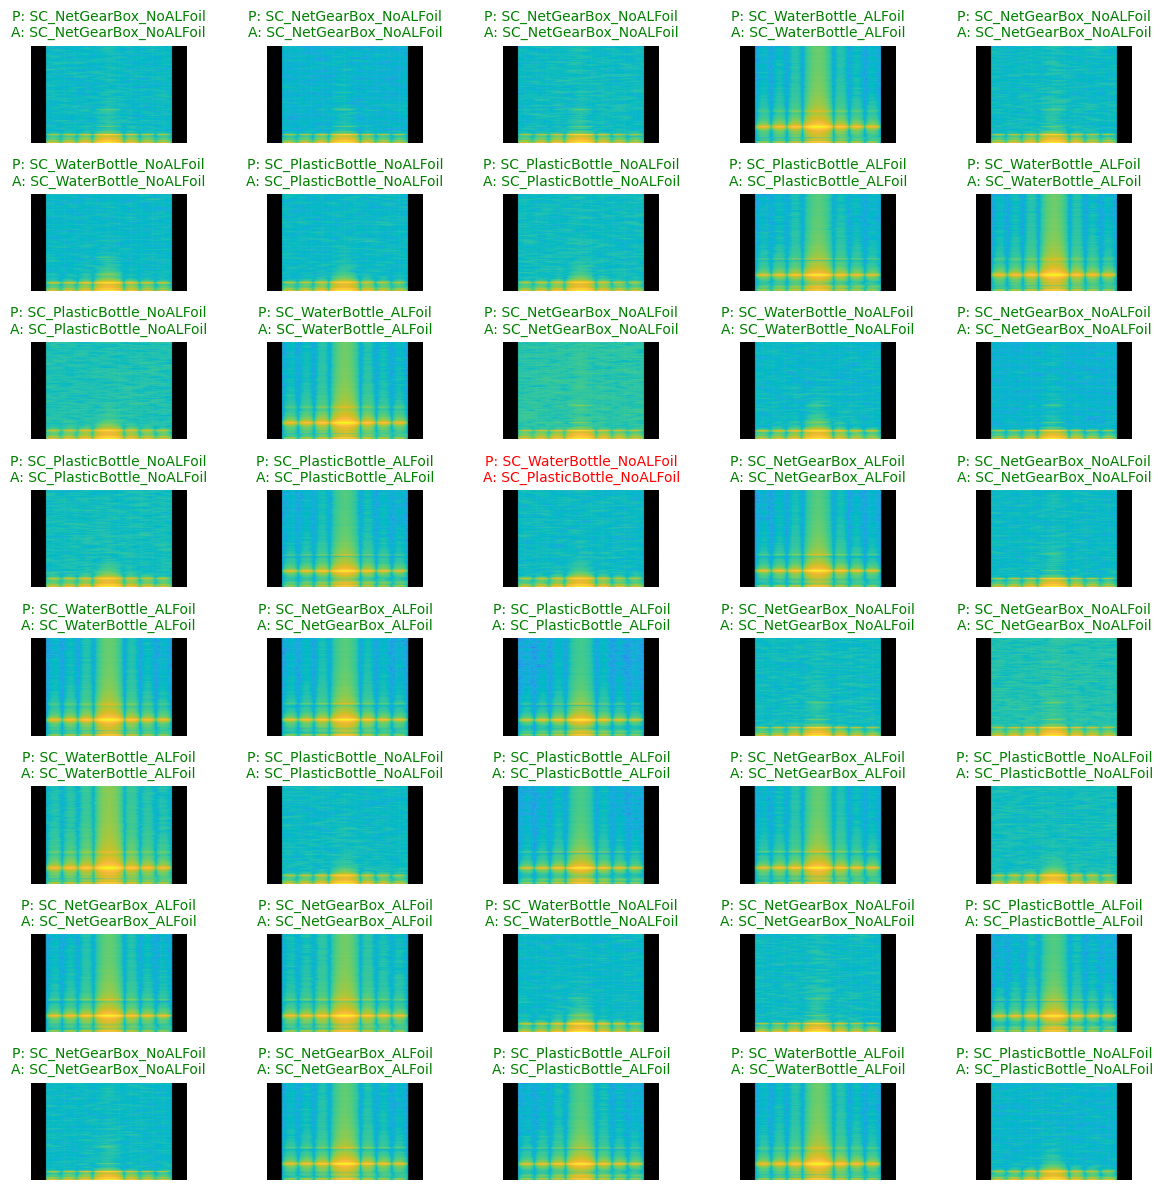

In [17]:
try:
    filepaths = test_generator.filepaths
except AttributeError:
    # fallback if .filepaths isn't available
    TEST_DIR = test_generator.directory
    filepaths = [os.path.join(TEST_DIR, fname) for fname in test_generator.filenames]

# pick 40 random indices
indices = random.sample(range(len(filepaths)), 40)

print("-----------------------------------------------------------------")
print("These are random images from the test dataset, there is no format")
print("-----------------------------------------------------------------")

plt.figure(figsize=(12, 12))
for i, idx in enumerate(indices):
    # load and convert BGR→RGB
    img = cv2.imread(filepaths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # lookup predicted vs actual
    pred_idx   = predicted_class_indices[idx]
    actual_idx = test_generator.classes[idx]
    pred_lbl   = inv_class_indices[pred_idx]
    actual_lbl = inv_class_indices[actual_idx]

    title_color = 'green' if pred_idx == actual_idx else 'red'

    ax = plt.subplot(8, 5, i + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"P: {pred_lbl}\nA: {actual_lbl}", color=title_color, fontsize=10)

plt.tight_layout()
plt.show()